In [38]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, TensorDataset
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from sklearn.metrics import classification_report
import numpy as np
import copy


In [39]:
# 시드 고정
torch.manual_seed(777)
IMAGE_SIZE = 128  # 이미지 크기 설정

# 디바이스 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

# 데이터 경로
data_dir = 'C:/src/archive/car_ori/'  # 실제 데이터 경로로 변경하세요

# 데이터 전처리 및 증강
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet 기준
                         [0.229, 0.224, 0.225])
])

# 원본 데이터셋 로드
dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
num_classes = len(dataset.classes)
print(f'클래스 수: {num_classes}')


클래스 수: 6


In [40]:
# 데이터셋 분할
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoader 설정
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# 클래스 분포 확인
labels = [label for _, label in dataset.samples]
label_counts = Counter(labels)
print(f'클래스 분포: {label_counts}')


클래스 분포: Counter({0: 300, 1: 300, 2: 300, 3: 300, 4: 300, 5: 300})


In [41]:
# 클래스 가중치 계산
class_weights = 1. / torch.tensor(list(label_counts.values()), dtype=torch.float).to(device)
print(f'클래스 가중치: {class_weights}')


클래스 가중치: tensor([0.0033, 0.0033, 0.0033, 0.0033, 0.0033, 0.0033])


In [42]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            # Conv Layer 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            # Conv Layer 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            # Conv Layer 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            # Conv Layer 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            # Conv Layer 5
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
            # Softmax는 CrossEntropyLoss에 의해 내부적으로 적용됩니다.
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# 모델 초기화
model = CNN(num_classes=num_classes).to(device)
print(model)


CNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (

In [43]:
# 손실 함수: CrossEntropyLoss (내부적으로 Softmax 포함)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# 최적화 기법: Adam
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning Rate Scheduler (옵션)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [44]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        """
        Args:
            patience (int): 손실이 개선되지 않아도 기다릴 에포크 수
            verbose (bool): 메시지 출력 여부
            delta (float): 개선으로 간주되는 최소 변화량
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
    
    def __call__(self, val_loss, model):
        score = -val_loss  # 손실을 최소화하므로 음수로 변환
        
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
    
    def save_checkpoint(self, val_loss, model):
        """가장 좋은 모델을 저장"""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), 'best_model.pt')
        self.val_loss_min = val_loss


In [45]:
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if batch_idx % 10 == 0:
            print(f'Batch [{batch_idx}/{len(train_loader)}] Loss: {loss.item():.4f}')
    
    epoch_loss = running_loss / len(train_loader)
    return epoch_loss

def evaluate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    val_loss /= len(val_loader)
    val_accuracy = correct / len(val_loader.dataset) * 100
    print(f'Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.2f}%')
    
    return val_loss, val_accuracy, all_preds, all_labels


In [46]:
# 조기 종료 객체 생성
early_stopping = EarlyStopping(patience=30, verbose=True, delta=0.001)

# 학습 루프 설정
epochs = 2

for epoch in range(1, epochs + 1):
    print(f'\nEpoch {epoch}/{epochs}')
    print('-' * 20)
    
    # 학습
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    print(f'Training Loss: {train_loss:.4f}')
    
    # 검증
    val_loss, val_accuracy, _, _ = evaluate(model, val_loader, criterion, device)
    
    # 조기 종료 체크
    early_stopping(val_loss, model)
    
    if early_stopping.early_stop:
        print("Early stopping triggered. Stopping training.")
        break
    
    # Learning Rate Scheduler 업데이트
    scheduler.step()



Epoch 1/2
--------------------
Batch [0/15] Loss: 1.7795
Batch [10/15] Loss: 2.0647
Training Loss: 2.1387
Validation Loss: 1.4843 | Validation Accuracy: 32.78%
Validation loss decreased (inf --> 1.484303). Saving model...

Epoch 2/2
--------------------
Batch [0/15] Loss: 1.7495
Batch [10/15] Loss: 1.5150
Training Loss: 1.5156
Validation Loss: 1.6731 | Validation Accuracy: 34.44%
EarlyStopping counter: 1 out of 30


In [47]:
# 저장된 모델 불러오기
model.load_state_dict(torch.load('best_model.pt'))
model.eval()


C:\Users\brown\AppData\Local\Temp\ipykernel_18380\4005145851.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


CNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (

예측된 클래스: G70, 확률: 0.3353


C:\Users\brown\AppData\Local\Temp\ipykernel_18380\1575766868.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


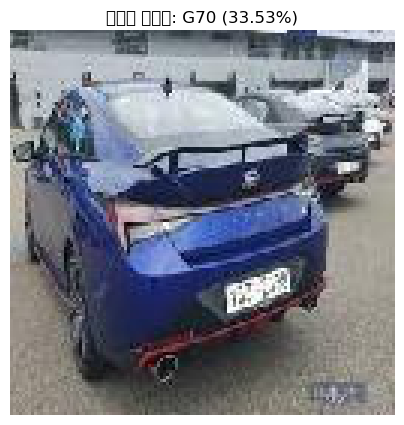

In [57]:
# test_model.py
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image

# 모델 정의 (훈련 시와 동일하게)
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# 클래스 라벨 (훈련 시 사용한 것과 동일해야 함)
class_names = ['AVANTE', 'CASPER', 'EV6', 'G70','K5','qm6'] 

# 모델 초기화 및 가중치 로드
model = CNN(num_classes=len(class_names))
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

# GPU 사용 가능 시 이동
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 이미지 전처리
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

def predict(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # 배치 차원 추가
    image = image.to(device)
    
    with torch.no_grad():
        outputs = model(image)
        probabilities = torch.softmax(outputs, dim=1)
        _, preds = torch.max(probabilities, 1)
        label = class_names[preds.item()]
        prob = probabilities[0][preds.item()].item()
    return label, prob
# 예제 사용
if __name__ == '__main__':
    # 파일 경로 수정: 원시 문자열 사용
    test_image_path = 'C:/src/archive/car_ori/AVANTE/AVANT (1).jpg'
  # 실제 테스트 이미지 경로로 변경하세요
    label, prob = predict(test_image_path)
    print(f'예측된 클래스: {label}, 확률: {prob:.4f}')

    # 테스트 이미지 예측 및 시각화
    test_image = Image.open(test_image_path).convert('RGB')  # 실제 이미지 경로로 변경
    plt.figure(figsize=(5,5))
    plt.imshow(test_image)
    plt.title(f'예측된 클래스: {label} ({prob*100:.2f}%)')
    plt.axis('off')
    plt.show()



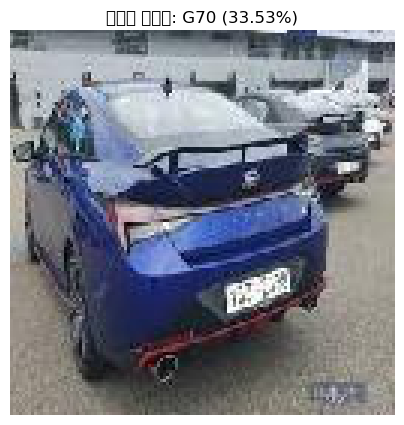

In [58]:
# 테스트 이미지 예측 및 시각화
test_image = Image.open('C:/src/archive/car_ori/AVANTE/AVANT (1).jpg').convert('RGB')  # 슬래시 사용

plt.figure(figsize=(5,5))
plt.imshow(test_image)
plt.title(f'예측된 클래스: {label} ({prob*100:.2f}%)')
plt.axis('off')
plt.show()
